<a href="https://colab.research.google.com/github/awitz23/master_thesis/blob/main/working_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#dependencies

In [2]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier


In [3]:
!pip install pm4py
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
import sys
import pm4py
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.auto import tqdm
# Pfad zu einem Ordner mit mehreren Dateien


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26094 sha256=d96051b3bd8b2841eb63d821bdaaa188c9c2608e61ea66f3106c00bb995a4d78
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=16969 sha256=2067be363c888c1e65f205fe7196c3a38699d898b5fe64deeaf806bc224c4de9
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist
Mounted at /content/drive


In [4]:

import pandas as pd
import pm4py
data_path = r"/content/drive/MyDrive/BPI_Challenge_2017.xes.gz"

In [5]:

if __name__ == "__main__":
    log = pm4py.read_xes(data_path)

df = log

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [6]:
log1 = log

In [7]:
log = log1

#Neuer Versuch, nach https://github.com/fmannhardt/starter-predictive-process-monitoring

Predictive Process Monitoring - A Starter Package for Jupyter

#Exploration

In [ ]:
#wie oft kommen die Arbeitsschritte im Eventlog vor
event_count = log['concept:name'].value_counts()
event_count

W_Validate application        209496
W_Call after offers           191092
W_Call incomplete files       168529
W_Complete application        148900
W_Handle leads                 47264
O_Create Offer                 42995
O_Created                      42995
O_Sent (mail and online)       39707
A_Validating                   38816
A_Create Application           31509
A_Concept                      31509
A_Accepted                     31509
A_Complete                     31362
O_Returned                     23305
A_Incomplete                   23055
O_Cancelled                    20898
A_Submitted                    20423
O_Accepted                     17228
A_Pending                      17228
A_Cancelled                    10431
O_Refused                       4695
A_Denied                        3753
W_Assess potential fraud        3282
O_Sent (online only)            2026
W_Shortened completion           238
W_Personal Loan collection        22
Name: concept:name, dtype: int64

In [ ]:
event_count

value_cases = "A_Create Application"
number_cases = event_count.loc[value_cases]


min_count = number_cases  # Der Mindestwert, wie oft ein Element vorkommen muss

events_smaller_cases = event_count.index[event_count <= min_count]

In [ ]:
(log['concept:name'].unique())

array(['A_Create Application', 'A_Submitted', 'W_Handle leads',
       'W_Complete application', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'W_Call after offers', 'A_Complete', 'W_Validate application',
       'A_Validating', 'O_Returned', 'W_Call incomplete files',
       'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused',
       'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Personal Loan collection',
       'W_Shortened completion '], dtype=object)

In [ ]:
names = (log['concept:name'].unique())

In [ ]:
#EXTREM WICHTIG: Filtere alle Arbeitsschritte die mit W_ anfangen heraus

# Verwende eine List Comprehension, um die Elemente zu filtern
filtered_elements = [element for element in names if element.startswith('O_')]

# 'filtered_elements' enthält alle Elemente aus 'my_array', die mit 'W_' beginnen
print((filtered_elements))

In [ ]:
log = log.loc[log["concept:name"].isin(filtered_elements)]

In [ ]:
#count unique Applications
print(log['case:concept:name'].nunique())

31509


In [ ]:
#get unique variants (--> variants = similar traces)
len(pm4py.get_variants_as_tuples(log))

877

In [ ]:
variants = pm4py.get_variants(log)

In [ ]:
# how does the process start
pm4py.get_start_activities(log_filtered)


{'A_Create Application': 31509}

In [ ]:
# how does the process end
pm4py.get_end_activities(log_filtered)

{'O_Cancelled': 14705,
 'A_Pending': 12791,
 'O_Refused': 3616,
 'A_Cancelled': 161,
 'W_Assess potential fraud': 102,
 'A_Complete': 43,
 'A_Incomplete': 36,
 'A_Denied': 33,
 'O_Sent (online only)': 13,
 'W_Shortened completion ': 5,
 'W_Personal Loan collection': 2,
 'O_Returned': 2}

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
#remove all "unnecessary" events
log_filtered = pm4py.filter_event_attribute_values(log,
                                    attribute_key = 'concept:name', # special column for the activity name always added by PM4Py
                                    values = events_smaller_cases,
                                    level = 'event',    # we want to keep all traces and modify events
                                    retain = True)     # remove matching events

In [ ]:
#dfg for filtered log
dfg, start_activities, end_activities = pm4py.discover_dfg(log_filtered)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
pm4py.get_event_attributes(log)

['Action',
 'org:resource',
 'concept:name',
 'EventOrigin',
 'EventID',
 'lifecycle:transition',
 'time:timestamp',
 'case:LoanGoal',
 'case:ApplicationType',
 'case:concept:name',
 'case:RequestedAmount',
 'FirstWithdrawalAmount',
 'NumberOfTerms',
 'Accepted',
 'MonthlyCost',
 'Selected',
 'CreditScore',
 'OfferedAmount',
 'OfferID',
 'start_timestamp']

In [ ]:
pm4py.get_event_attribute_values(log, 'NumberOfTerms')

{120.0: 8463,
 60.0: 4402,
 126.0: 2457,
 127.0: 1750,
 36.0: 1524,
 58.0: 1489,
 48.0: 1279,
 56.0: 1249,
 72.0: 984,
 138.0: 842,
 134.0: 831,
 24.0: 790,
 57.0: 772,
 80.0: 521,
 96.0: 504,
 78.0: 477,
 45.0: 454,
 84.0: 447,
 37.0: 414,
 89.0: 410,
 27.0: 371,
 100.0: 357,
 55.0: 356,
 180.0: 349,
 69.0: 343,
 90.0: 342,
 44.0: 276,
 65.0: 241,
 50.0: 239,
 18.0: 233,
 54.0: 232,
 77.0: 225,
 68.0: 213,
 42.0: 202,
 108.0: 202,
 30.0: 194,
 66.0: 194,
 59.0: 192,
 81.0: 189,
 88.0: 185,
 40.0: 183,
 12.0: 175,
 22.0: 173,
 70.0: 169,
 82.0: 168,
 47.0: 165,
 62.0: 164,
 101.0: 163,
 67.0: 162,
 74.0: 160,
 33.0: 159,
 102.0: 154,
 75.0: 149,
 86.0: 148,
 32.0: 148,
 46.0: 142,
 71.0: 141,
 76.0: 141,
 61.0: 135,
 64.0: 134,
 110.0: 134,
 85.0: 130,
 49.0: 128,
 94.0: 127,
 41.0: 126,
 79.0: 126,
 26.0: 119,
 87.0: 116,
 39.0: 116,
 31.0: 111,
 95.0: 107,
 52.0: 106,
 98.0: 106,
 105.0: 104,
 21.0: 104,
 43.0: 103,
 104.0: 103,
 63.0: 103,
 38.0: 97,
 106.0: 94,
 51.0: 90,
 111.0: 8

#Preprocessing

Prefixes

In [8]:
#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

from pm4py.objects.log.obj import EventLog, Trace
# generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

log_prefixes_Accepted["label"] = "accepted"
log_prefixes_Cancelled["label"] = "not"
log_prefixes_Denied["label"] = "not"

#generate df of log prefixes with length = value in length
trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=20, case_id_key='case:concept:name')
trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=20, case_id_key='case:concept:name')
trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=20, case_id_key='case:concept:name')

data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)


In [9]:
log_prefixes_Accepted["label"] = "accepted"
log_prefixes_Cancelled["label"] = "not"
log_prefixes_Denied["label"] = "not"


In [10]:
#generate df of log prefixes with length = value in length
trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=20, case_id_key='case:concept:name')
trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=20, case_id_key='case:concept:name')
trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=20, case_id_key='case:concept:name')


In [11]:
#count unique Applications
print(log_prefixes_Cancelled['case:concept:name'].nunique())

10431


In [12]:
data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)

In [13]:
data_labeled_prefixes


,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,@@index_in_trace,@@temp_column,label
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,38.0,accepted
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,38.0,accepted
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,38.0,accepted
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,38.0,accepted
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,38.0,accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202259,Obtained,User_96,W_Call after offers,Workflow,Workitem_358206591,start,2017-01-02 19:27:20.472000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,18.0,not
1202260,statechange,User_96,A_Complete,Application,ApplState_1120616436,complete,2017-01-02 19:27:20.474000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,18.0,not
1202261,Released,User_96,W_Call after offers,Workflow,Workitem_146325658,suspend,2017-01-02 19:29:25.989000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,18.0,not
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,18.0,not


In [14]:

list_1 = data_labeled_prefixes['label'].tolist()




In [15]:
print(list_1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
list_1 = data_labeled_prefixes['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
list_3.shape

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(613567,)

In [17]:
list_3 = np.asarray(list_2).astype(int)
list_3.shape

(613567,)

In [18]:
np.unique(list_2, return_counts=True)


(array([False,  True]), array([269013, 344554]))

In [19]:
list_3

array([1, 1, 1, ..., 0, 0, 0])

prefix buckets

In [20]:
d = {}
i=0
for i in range(21):

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

  from pm4py.objects.log.obj import EventLog, Trace
  # generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
  log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

  log_prefixes_Accepted["label"] = "accepted"
  log_prefixes_Cancelled["label"] = "not"
  log_prefixes_Denied["label"] = "not"

  #generate df of log prefixes with length = value in length
  trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=i, case_id_key='case:concept:name')
  trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=i, case_id_key='case:concept:name')
  trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=i, case_id_key='case:concept:name')

  data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)
  #print(data_labeled_prefixes.head(10))

  id_counts = data_labeled_prefixes['case:concept:name'].value_counts()

  # IDs auswählen, die genau i-mal auftreten
  valid_ids = id_counts[id_counts == i].index

  # DataFrame filtern, um nur die ausgewählten IDs zu behalten
  filtered_df = data_labeled_prefixes[data_labeled_prefixes['case:concept:name'].isin(valid_ids)]

  d['data_labeled_prefixes{0}'.format(i)] = filtered_df



  i+=1

  print(i)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [82]:
d['data_labeled_prefixes18']["case:concept:name"].nunique()

29118

#encoding

In [32]:
#das Funktioniert !
#Spalten einfach die dynamic event cat. angeben
spalten = ['concept:name', 'org:resource', 'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(d['data_labeled_prefixes18'], values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)


# Ergebnisse anzeigen
#for spalte, pivot_table in zip(spalten, pivot_tables):
 #   if ergebnis_df.empty:
  #      ergebnis_df = pivot_table
   # else:
    #    ergebnis_df = ergebnis_df.join(pivot_table, on=spalte, rsuffix=f'_{spalte}')

    #print(f"Pivot-Tabelle für Spalte {spalte}:")
    #print(pivot_table)
    #print("\n")

#print(len(pivot_tables[1]))

29118


In [ ]:
#fügt alle dynamic cat event attributes in ein df.

combined_df = pd.concat([pivot_tables[0], pivot_tables[1], pivot_tables[2]])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

# Ergebnis anzeigen
#print(df_dynamic_event_cat)

# Ergebnis anzeigen
#print(combined_df)

In [34]:
#static trace cat
work_around = pd.DataFrame()
work_around = d['data_labeled_prefixes18'][['case:concept:name',"case:LoanGoal",'case:ApplicationType','case:RequestedAmount',"label"]]
work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")




In [35]:
work_around_feature_table = pd.get_dummies(work_around)
work_around_feature_table

,case:RequestedAmount,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit,label_accepted,label_not
case:concept:name,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
Application_428409768,15000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
Application_1746793196,5000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
Application_619403287,15000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
Application_1529124572,5000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_188935499,21000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
Application_1986755838,16500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
Application_380535005,25000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [36]:
#Labels extrahieren

list_1 = work_around['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [37]:
#DF all infos
df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

In [38]:
df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

##FINALES ENCODEDED DF FÜR ML ALGO !!!!!!!!

                        A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                           
Application_652823628                    1.0          1.0             2.0   
Application_428409768                    1.0          1.0             2.0   
Application_1746793196                   1.0          1.0             3.0   
Application_619403287                    1.0          1.0             2.0   
Application_1529124572                   1.0          1.0             2.0   
...                                      ...          ...             ...   
Application_188935499                    1.0          1.0             2.0   
Application_1986755838                   1.0          1.0             4.0   
Application_380535005                    1.0          1.0             2.0   
Application_1722592475                   1.0          1.0             2.0   
Application_1350494635                   1.0          1.0             2.0   

#Data Scaling

In [29]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(df_all_infos)

scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
target_scaled = scaler_y.fit_transform(list_3.reshape(-1, 1))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_all_infos, list_3, test_size=0.33, random_state=42)

In [31]:
#X_train

array([[0.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 1.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 1.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.   , 0.   , 1.   ],
       [0.   , 1.   , 0.125, ..., 0.   , 0.   , 1.   ],
       [0.   , 1.   , 0.125, ..., 0.   , 0.   , 1.   ]])

#Punkt: Predict Data erzeugen

In [149]:
New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['case:concept:name'] == "Application_652823628"]

#New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['label'] == "accepted"]

# Ergebnis anzeigen
print(New_Data)

#New data entspricht dem Teil des Dataframes für einen Trace ! So muss das noch gecodet werden

         Action org:resource              concept:name  EventOrigin  \
0       Created       User_1      A_Create Application  Application   
1   statechange       User_1               A_Submitted  Application   
2       Created       User_1            W_Handle leads     Workflow   
3       Deleted       User_1            W_Handle leads     Workflow   
4       Created       User_1    W_Complete application     Workflow   
5   statechange       User_1                 A_Concept  Application   
6      Obtained      User_17    W_Complete application     Workflow   
7      Released      User_17    W_Complete application     Workflow   
8   statechange      User_52                A_Accepted  Application   
9       Created      User_52            O_Create Offer        Offer   
10  statechange      User_52                 O_Created        Offer   
11  statechange      User_52  O_Sent (mail and online)        Offer   
12      Deleted      User_52    W_Complete application     Workflow   
13    

In [150]:
d['data_labeled_prefixes18'].head(5)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,@@index_in_trace,@@temp_column,label
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,38.0,accepted
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,38.0,accepted
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,38.0,accepted
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,38.0,accepted
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,38.0,accepted


In [151]:
spalten = ['concept:name', 'org:resource', 'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(New_Data, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)

combined_df = pd.concat([pivot_tables[0], pivot_tables[1], pivot_tables[2]])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

work_around = pd.DataFrame()
work_around = New_Data[['case:concept:name',"case:LoanGoal",'case:ApplicationType','case:RequestedAmount',"label"]]
work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")

work_around_feature_table = pd.get_dummies(work_around)

df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
#df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

                       A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                          
Application_652823628                   1.0          1.0             2.0   

                       W_Complete application  A_Concept  A_Accepted  \
case:concept:name                                                      
Application_652823628                     4.0        1.0         1.0   

                       O_Create Offer  O_Created  O_Sent (mail and online)  \
case:concept:name                                                            
Application_652823628             1.0        1.0                       1.0   

                       W_Call after offers  ...  User_17  User_52  User_11  \
case:concept:name                           ...                              
Application_652823628                  4.0  ...      2.0      9.0      1.0   

                       Application  Workflow  Offer  case:RequestedAmount  \
case:co

In [152]:
new_df_data = pd.DataFrame(0, columns=X_train.columns, index=df_all_infos.index)

# Aktualisieren Sie die Spalten aus df_data in new_df_data
for column in new_df_data.columns:
  if column in df_all_infos.columns:
    new_df_data[column] = df_all_infos[column]

# Ergebnis anzeigen
#print(new_df_data)



In [153]:
pivot_tables[0]

concept:name,A_Create Application,A_Submitted,W_Handle leads,W_Complete application,A_Concept,A_Accepted,O_Create Offer,O_Created,O_Sent (mail and online),W_Call after offers,A_Complete
case:concept:name,,,,,,,,,,,
Application_652823628,1,1,2,4,1,1,1,1,1,4,1


#Model

#Random Forest

In [49]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [50]:
preds = clf.predict(X_test)


In [58]:
print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6665641498795428
0.6360703507128733


In [52]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds,  labels = [1, 2])


array([[4140,    0],
       [   0,    0]])

In [53]:
print(preds)

[0 1 1 ... 1 0 1]


#Gradient Boosting

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

In [57]:
#n_estimator = 100
print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6665641498795428
0.6360703507128733


In [154]:
predicted_class = clf.predict(new_df_data)
print(predicted_class)

[1]


In [155]:
unique, counts = np.unique(predicted_class, return_counts=True)

print(np.asarray((unique, counts)).T)

[[1 1]]


#Explainer

In [156]:
!pip install shap
import shap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization


In [157]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [160]:
#shap.force_plot(explainer.expected_value, shap_values, X_train)

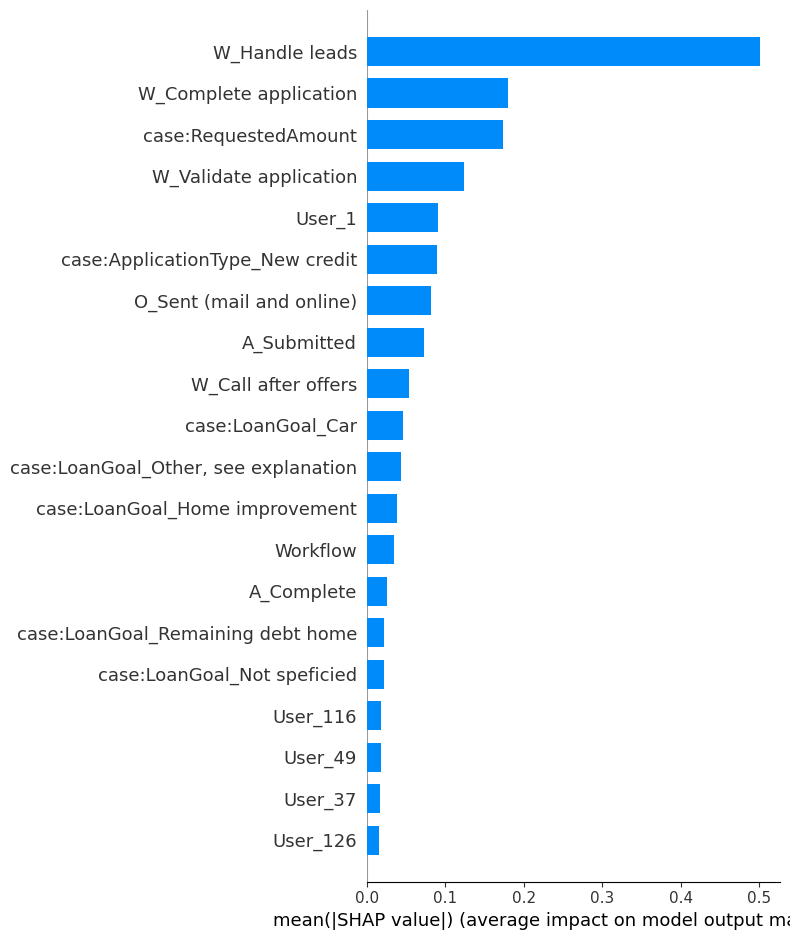

In [162]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


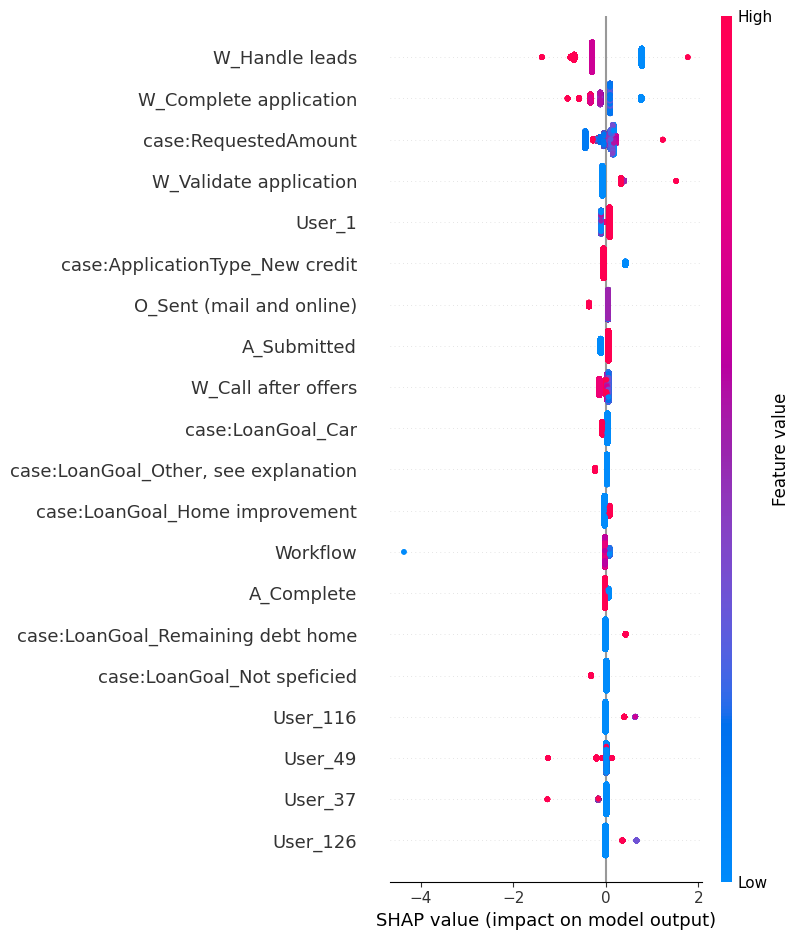

In [163]:
shap.summary_plot(shap_values, X_train)

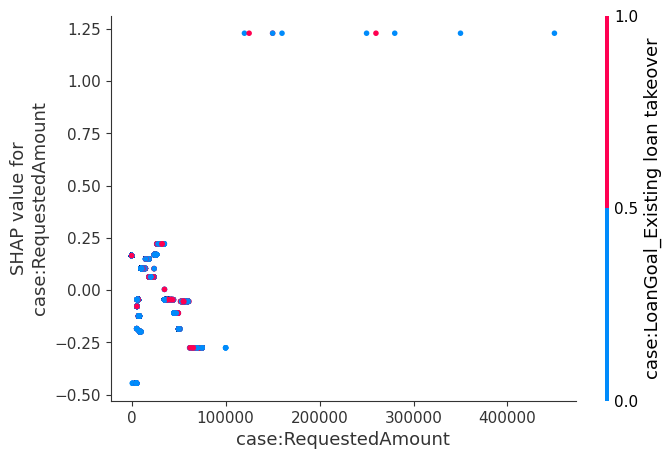

In [169]:
shap.dependence_plot('case:RequestedAmount', shap_values, X_train)

#Not too important

In [46]:
import pandas as pd
import pm4py
import numpy as np
import sklearn
import torch
import torch.nn as nn
from tqdm.auto import tqdm

In [47]:
class NeuralNetworkBinaryOutcome(nn.Module):
    def __init__(self):
        super(NeuralNetworkBinaryOutcome, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            torch.nn.Linear(x.shape[1], 64),
            nn.BatchNorm1d(num_features=64),
            nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            nn.BatchNorm1d(num_features=128),
            torch.nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [48]:
def train(dataloader, model,
          loss_fn, measure_fn,
          optimizer, device, epochs):

    losses = []
    size = len(dataloader.dataset)

    loop = tqdm(range(epochs))

    for epoch in loop:

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction error
            pred = model(X)

            loss = loss_fn(pred, y)
            measure = measure_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()

            losses.append([loss.item(), measure.item()])

        loop.set_description('Epoch {}/{}'.format(epoch + 1, epochs))
        loop.set_postfix(loss=loss.item(), measure=measure.item())

    return losses

In [49]:
def evaluate_all(dataloader, model, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()

    result = []
    original = []

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            result.extend(pred.flatten().numpy())
            original.extend(y.flatten().numpy())

    return np.asarray(result), np.asarray(original)

In [50]:
from torch.utils.data import TensorDataset, DataLoader

# We need float32 data
x = torch.from_numpy(data_scaled.astype('float32'))
y = torch.from_numpy(target_scaled.astype('float32'))

print(x)
print(y)
# Always check the shapes
print(x.shape)
print(y.shape)

ds = TensorDataset(x, y)
train_dataloader = DataLoader(ds, batch_size=64, shuffle=True)

tensor([[0.0000, 1.0000, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.5000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.0000, 1.0000, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.3333,  ..., 0.0000, 0.0000, 1.0000]])
tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])
torch.Size([31393, 156])
torch.Size([31393, 1])


In [51]:
inputs, classes = next(iter(train_dataloader))
print(inputs[0])
print(classes[0])

tensor([0.0000, 1.0000, 0.3333, 0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.8571, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [52]:
## if you want ot use a GPU you need to tweak the requirements.txt to include the GPU-enabled PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# fix a seed to get reproducible results
torch.manual_seed(42)

model = NeuralNetworkBinaryOutcome().to(device)
print(model)

def get_accuracy(y_prob, y_true):
    y_true = y_true.flatten()
    y_prob = y_prob.flatten()
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum() / y_true.size(0)
measure_fn = get_accuracy

results = train(train_dataloader, model,
                nn.BCELoss(), # crossentropy for binary target
                get_accuracy,
                torch.optim.Adam(model.parameters()),
                device, 100)

Using cpu device
NeuralNetworkBinaryOutcome(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=156, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=128, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


  0%|          | 0/100 [00:00<?, ?it/s]

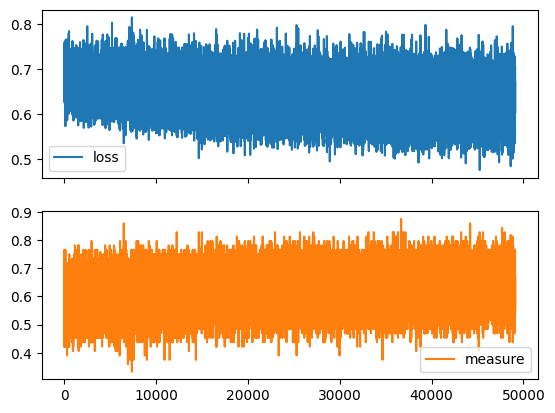

In [53]:
%matplotlib inline

results_data = pd.DataFrame(results)
results_data.columns = ['loss', 'measure']
ax = results_data.plot(subplots=True);

In [54]:
print("Accuracy: " + str(results[len(results)-1][1]))

true_returns = np.unique(list_3, return_counts= True)[1][0]
true_not_returns = np.unique(list_3, return_counts= True)[1][1]

print("Accuracy (never returns)" + str(true_returns / len(list_3)))
print("Accuracy (always returns)" + str(true_not_returns / len(list_3)))

Accuracy: 0.5454545617103577
Accuracy (never returns)0.45121523906603384
Accuracy (always returns)0.5487847609339662


In [55]:
print("Accuracy: " + str(results[len(results)-1][1]))

true_returns = np.unique(list_3, return_counts= True)[1][0]
true_not_returns = np.unique(list_3, return_counts= True)[1][1]

print("Accuracy (never returns)" + str(true_returns / len(list_3)))
print("Accuracy (always returns)" + str(true_not_returns / len(list_3)))

Accuracy: 0.5454545617103577
Accuracy (never returns)0.45121523906603384
Accuracy (always returns)0.5487847609339662


#Evaluation

In [ ]:
test_dataloader = DataLoader(ds, batch_size=256, shuffle=False)
result, original = evaluate_all(test_dataloader, model, device)

  0%|          | 0/123 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

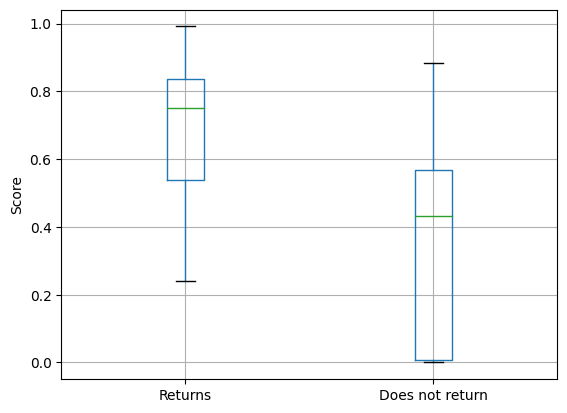

In [ ]:
pd_pos = pd.DataFrame({'Returns': result[original == 1]})
pd_neg = pd.DataFrame({'Does not return': result[original == 0]})
pd.concat([pd_pos, pd_neg],axis=1).boxplot().set_ylabel('Score')

Text(0, 0.5, 'Frequency')

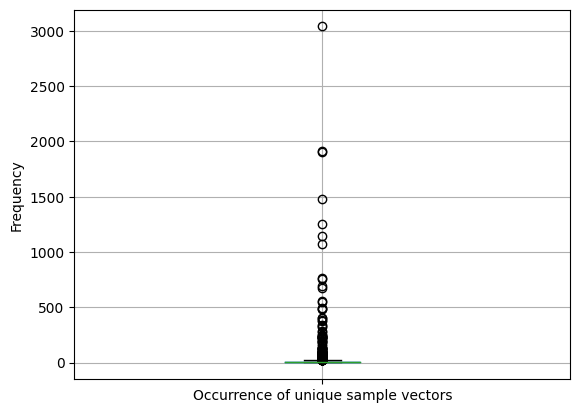

In [ ]:
# count the unique vectors
dist_bags = np.unique(sepsis_bag, return_counts=True, axis=0)

# sort them with numpy
unique_vectors = dist_bags[0][np.argsort(-dist_bags[1])]
count_vectors = dist_bags[1][np.argsort(-dist_bags[1])]

pd.DataFrame({'Occurrence of unique sample vectors': count_vectors}).boxplot().set_ylabel('Frequency')

In [ ]:
# most frequently used vector
unique_vectors[0]

array([1, 0, 0, 3, 1, 1, 1, 1, 1, 6, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
# find the sample indicies for this vector
sample_indicies = np.where((sepsis_bag == unique_vectors[0]).all(axis=1))
sample_durations = target_scaled[sample_indicies]

In [ ]:
np.unique(sample_durations, return_counts=True)

(array([0, 1]), array([ 504, 2536]))

#Alter Versuch nach
https://github.com/irhete/predictive-monitoring-benchmark/blob/master/bucketers/NoBucketer.py

"Outcome-Oriented Predictive Process Monitoring: Review and Benchmark" von Teinemaa et. al.

In [ ]:
print(dt_labeled.columns.tolist())

#Preprocessing

In [ ]:
df = log

In [ ]:
data=df.head(1000)

In [ ]:


#input_data_folder = "../orig_logs/bpic2017"
#output_data_folder = "../labeled_logs_csv_processed"
#filenames = ["BPIC17.csv"]

case_id_col = "case:concept:name"
activity_col = "concept:name"
resource_col = 'org:resource'
timestamp_col = 'time:timestamp'
label_col = "label"
pos_label = "deviant"
neg_label = "regular"

relevant_offer_events = ["O_Cancelled", "O_Accepted", "O_Refused"]

resource_freq_threshold = 10
max_category_levels = 10

# features for classifier
dynamic_cat_cols = [activity_col, resource_col, 'Action', 'CreditScore', 'EventOrigin', 'lifecycle:transition',
                   "Accepted", "Selected"] # i.e. event attributes
static_cat_cols = ['case:ApplicationType', 'case:LoanGoal'] # i.e. case attributes that are known from the start
dynamic_num_cols = ['FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount',
                   "timesincelastevent", "timesincecasestart", "timesincemidnight", "event_nr", "month", "weekday", "hour",
                    "open_cases"]
static_num_cols = ['case:RequestedAmount']

static_cols = static_cat_cols + static_num_cols + [case_id_col, label_col]
dynamic_cols = dynamic_cat_cols + dynamic_num_cols + [timestamp_col]
cat_cols = dynamic_cat_cols + static_cat_cols


def extract_timestamp_features(group):

    group = group.sort_values(timestamp_col, ascending=False, kind='mergesort')

    tmp = group[timestamp_col] - group[timestamp_col].shift(-1)
    tmp = tmp.fillna(pd.Timedelta(seconds=0))
    group["timesincelastevent"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'm'))) # m is for minutes

    tmp = group[timestamp_col] - group[timestamp_col].iloc[-1]
    tmp = tmp.fillna(pd.Timedelta(seconds=0))
    group["timesincecasestart"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'm'))) # m is for minutes

    group = group.sort_values(timestamp_col, ascending=True, kind='mergesort')
    group["event_nr"] = range(1, len(group) + 1)

    return group

def get_open_cases(date):
    return sum((dt_first_last_timestamps["start_time"] <= date) & (dt_first_last_timestamps["end_time"] > date))



In [ ]:

for df in data:

 #   data = pd.read_csv(os.path.join(input_data_folder,filename), sep=";")

    # add event duration
    data[timestamp_col] = pd.to_datetime(data[timestamp_col])
    data["timesincemidnight"] = data[timestamp_col].dt.hour * 60 + data[timestamp_col].dt.minute
    data["month"] = data[timestamp_col].dt.month
    data["weekday"] = data[timestamp_col].dt.weekday
    data["hour"] = data[timestamp_col].dt.hour

    # add features extracted from timestamp
    print("Extracting timestamp features...")
    sys.stdout.flush()
    data = data.groupby(case_id_col).apply(extract_timestamp_features)

    # add inter-case features
    print("Extracting open cases...")
    sys.stdout.flush()
    data = data.sort_values([timestamp_col], ascending=True, kind='mergesort')
    dt_first_last_timestamps = data.groupby(case_id_col)[timestamp_col].agg([min, max])
    dt_first_last_timestamps.columns = ["start_time", "end_time"]
    data["open_cases"] = data[timestamp_col].apply(get_open_cases)

    # assign class labels
    print("Assigning class labels...")
    sys.stdout.flush()
    last_o_events = data[data.EventOrigin == "Offer"].sort_values(timestamp_col, ascending=True, kind='mergesort').groupby(case_id_col).last()[activity_col]
    last_o_events = pd.DataFrame(last_o_events)
    last_o_events.columns = ["last_o_activity"]
    data = data.merge(last_o_events, left_on=case_id_col, right_index=True)
    data = data[data.last_o_activity.isin(relevant_offer_events)]

    for activity in relevant_offer_events:
        print("Finishing dataset for activity ", activity)
        sys.stdout.flush()
        dt_labeled = data.copy()
        dt_labeled[label_col] = neg_label
        dt_labeled.loc[dt_labeled["last_o_activity"] == activity, label_col] = pos_label

        dt_labeled = dt_labeled[static_cols + dynamic_cols]

        # impute missing values
        grouped = dt_labeled.sort_values(timestamp_col, ascending=True, kind='mergesort').groupby(case_id_col)
        for col in static_cols + dynamic_cols:
            dt_labeled[col] = grouped[col].transform(lambda grp: grp.fillna(method='ffill'))

        dt_labeled[cat_cols] = dt_labeled[cat_cols].fillna('missing')
        dt_labeled = dt_labeled.fillna(0)

        # set infrequent factor levels to "other"
        for col in cat_cols:
            if col == resource_col:
                counts = dt_labeled[col].value_counts()
                mask = dt_labeled[col].isin(counts[counts >= resource_freq_threshold].index)
                dt_labeled.loc[~mask, col] = "other"
            elif col != activity_col:
                counts = dt_labeled[col].value_counts()
                mask = dt_labeled[col].isin(counts.index[max_category_levels:])
                dt_labeled.loc[mask, col] = "other"
    print('erster Durchgang fucking DONE')
        #dt_labeled.to_csv(os.path.join(output_data_folder, "%s_%s.csv" % (filename[:-4], activity)), sep=";", index=False)
print(dt_labeled)

Extracting timestamp features...
Extracting open cases...


<ipython-input-93-125b784a253e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[timestamp_col] = pd.to_datetime(data[timestamp_col])
<ipython-input-93-125b784a253e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["timesincemidnight"] = data[timestamp_col].dt.hour * 60 + data[timestamp_col].dt.minute
<ipython-input-93-125b784a253e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Assigning class labels...
Finishing dataset for activity  O_Cancelled
Finishing dataset for activity  O_Accepted
Finishing dataset for activity  O_Refused
erster Durchgang fucking DONE
Extracting timestamp features...
Extracting open cases...


<ipython-input-93-125b784a253e>:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(case_id_col).apply(extract_timestamp_features)


Assigning class labels...


AttributeError: ignored

#Bucketer

In [ ]:
import pandas as pd
import numpy as np
from time import time
import sys

class PrefixLengthBucketer(object):

    def __init__(self, case_id_col):
        self.n_states = 0
        self.case_id_col = case_id_col


    def fit(self, X, y=None):

        sizes = X.groupby(self.case_id_col).size()
        self.n_states = sizes.unique()
        print(self.n_states)

        return self


    def predict(self, X, y=None):

        bucket_assignments = X.groupby(self.case_id_col).size()
        while sum(~bucket_assignments.isin(self.n_states)) > 0:
            bucket_assignments[~bucket_assignments.isin(self.n_states)] -= 1
        return bucket_assignments.as_matrix()


    def fit_predict(self, X, y=None):

        self.fit(X)
        return self.predict(X)

#Encoder

In [ ]:
from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np
from time import time
import sys

class AggregateTransformer(TransformerMixin):

    def __init__(self, case_id_col, cat_cols, num_cols, boolean=False, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols

        self.boolean = boolean
        self.fillna = fillna

        self.columns = None

        self.fit_time = 0
        self.transform_time = 0


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        start = time()

        # transform numeric cols
        if len(self.num_cols) > 0:
            dt_numeric = X.groupby(self.case_id_col)[self.num_cols].agg({'mean':np.mean, 'max':np.max, 'min':np.min, 'sum':np.sum, 'std':np.std})
            dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]

        # transform cat cols
        dt_transformed = pd.get_dummies(X[self.cat_cols])
        dt_transformed[self.case_id_col] = X[self.case_id_col]
        del X
        if self.boolean:
            dt_transformed = dt_transformed.groupby(self.case_id_col).max()
        else:
            dt_transformed = dt_transformed.groupby(self.case_id_col).sum()

        # concatenate
        if len(self.num_cols) > 0:
            dt_transformed = pd.concat([dt_transformed, dt_numeric], axis=1)
            del dt_numeric

        # fill missing values with 0-s
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)

        # add missing columns if necessary
        if self.columns is None:
            self.columns = dt_transformed.columns
        else:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]

        self.transform_time = time() - start
        return dt_transformed

    def get_feature_names(self):
        return self.columns

#Running instance

encoder factory

In [ ]:
#from transformers.StaticTransformer import StaticTransformer
#from transformers.LastStateTransformer import LastStateTransformer
#from transformers.AggregateTransformer import AggregateTransformer
#from transformers.IndexBasedTransformer import IndexBasedTransformer

def get_encoder(method, case_id_col=None, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=None,
                dynamic_num_cols=None, fillna=True, max_events=None, activity_col=None, resource_col=None, timestamp_col=None,
                scale_model=None):

    if method == "static":
        return StaticTransformer(case_id_col=case_id_col, cat_cols=static_cat_cols, num_cols=static_num_cols, fillna=fillna)

    elif method == "last":
        return LastStateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, fillna=fillna)

    elif method == "agg":
        return AggregateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, boolean=False, fillna=fillna)

    elif method == "bool":
        return AggregateTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, boolean=True, fillna=fillna)

    elif method == "index":
        return IndexBasedTransformer(case_id_col=case_id_col, cat_cols=dynamic_cat_cols, num_cols=dynamic_num_cols, max_events=max_events, fillna=fillna)

    else:
        print("Invalid encoder type")
        return None

Bucket factory

In [ ]:
#import EncoderFactory

#from bucketers.ClusterBasedBucketer import ClusterBasedBucketer
#from bucketers.StateBasedBucketer import StateBasedBucketer
#from bucketers.PrefixLengthBucketer import PrefixLengthBucketer
#from bucketers.NoBucketer import NoBucketer
#from bucketers.KNNBucketer import KNNBucketer
#from sklearn.cluster import KMeans


def get_bucketer(method, encoding_method=None, case_id_col=None, cat_cols=None, num_cols=None, n_clusters=None, random_state=None, n_neighbors=None):

    if method == "cluster":
        bucket_encoder = EncoderFactory.get_encoder(method=encoding_method, case_id_col=case_id_col, dynamic_cat_cols=cat_cols, dynamic_num_cols=num_cols)
        clustering = KMeans(n_clusters, random_state=random_state)
        return ClusterBasedBucketer(encoder=bucket_encoder, clustering=clustering)

    elif method == "state":
        bucket_encoder = EncoderFactory.get_encoder(method=encoding_method, case_id_col=case_id_col, dynamic_cat_cols=cat_cols, dynamic_num_cols=num_cols)
        return StateBasedBucketer(encoder=bucket_encoder)

    elif method == "single":
        return NoBucketer(case_id_col=case_id_col)

    elif method == "prefix":
        return PrefixLengthBucketer(case_id_col=case_id_col)

    elif method == "knn":
        bucket_encoder = EncoderFactory.get_encoder(method=encoding_method, case_id_col=case_id_col, dynamic_cat_cols=cat_cols, dynamic_num_cols=num_cols)
        return KNNBucketer(encoder=bucket_encoder, n_neighbors=n_neighbors)

    else:
        print("Invalid bucketer type")
        return None

Dataset Manager

In [ ]:
import sys

#import dataset_confs

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold


class DatasetManager:

    def __init__(self, dataset_name):
        self.dataset_name = dataset_name

        self.case_id_col = dataset_confs.case_id_col[self.dataset_name]
        self.activity_col = dataset_confs.activity_col[self.dataset_name]
        self.timestamp_col = dataset_confs.timestamp_col[self.dataset_name]
        self.label_col = dataset_confs.label_col[self.dataset_name]
        self.pos_label = dataset_confs.pos_label[self.dataset_name]

        self.dynamic_cat_cols = dataset_confs.dynamic_cat_cols[self.dataset_name]
        self.static_cat_cols = dataset_confs.static_cat_cols[self.dataset_name]
        self.dynamic_num_cols = dataset_confs.dynamic_num_cols[self.dataset_name]
        self.static_num_cols = dataset_confs.static_num_cols[self.dataset_name]

        self.sorting_cols = [self.timestamp_col, self.activity_col]


    def read_dataset(self):
        # read dataset
        dtypes = {col:"object" for col in self.dynamic_cat_cols+self.static_cat_cols+[self.case_id_col, self.label_col, self.timestamp_col]}
        for col in self.dynamic_num_cols + self.static_num_cols:
            dtypes[col] = "float"

        data = pd.read_csv(dataset_confs.filename[self.dataset_name], sep=";", dtype=dtypes)
        data[self.timestamp_col] = pd.to_datetime(data[self.timestamp_col])

        return data


    def split_data(self, data, train_ratio, split="temporal", seed=22):
        # split into train and test using temporal split

        grouped = data.groupby(self.case_id_col)
        start_timestamps = grouped[self.timestamp_col].min().reset_index()
        if split == "temporal":
            start_timestamps = start_timestamps.sort_values(self.timestamp_col, ascending=True, kind="mergesort")
        elif split == "random":
            np.random.seed(seed)
            start_timestamps = start_timestamps.reindex(np.random.permutation(start_timestamps.index))
        train_ids = list(start_timestamps[self.case_id_col])[:int(train_ratio*len(start_timestamps))]
        train = data[data[self.case_id_col].isin(train_ids)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
        test = data[~data[self.case_id_col].isin(train_ids)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')

        return (train, test)

    def split_data_strict(self, data, train_ratio, split="temporal"):
        # split into train and test using temporal split and discard events that overlap the periods
        data = data.sort_values(self.sorting_cols, ascending=True, kind='mergesort')
        grouped = data.groupby(self.case_id_col)
        start_timestamps = grouped[self.timestamp_col].min().reset_index()
        start_timestamps = start_timestamps.sort_values(self.timestamp_col, ascending=True, kind='mergesort')
        train_ids = list(start_timestamps[self.case_id_col])[:int(train_ratio*len(start_timestamps))]
        train = data[data[self.case_id_col].isin(train_ids)].sort_values(self.sorting_cols, ascending=True, kind='mergesort')
        test = data[~data[self.case_id_col].isin(train_ids)].sort_values(self.sorting_cols, ascending=True, kind='mergesort')
        split_ts = test[self.timestamp_col].min()
        train = train[train[self.timestamp_col] < split_ts]
        return (train, test)

    def split_data_discard(self, data, train_ratio, split="temporal"):
        # split into train and test using temporal split and discard events that overlap the periods
        data = data.sort_values(self.sorting_cols, ascending=True, kind='mergesort')
        grouped = data.groupby(self.case_id_col)
        start_timestamps = grouped[self.timestamp_col].min().reset_index()
        start_timestamps = start_timestamps.sort_values(self.timestamp_col, ascending=True, kind='mergesort')
        train_ids = list(start_timestamps[self.case_id_col])[:int(train_ratio*len(start_timestamps))]
        train = data[data[self.case_id_col].isin(train_ids)].sort_values(self.sorting_cols, ascending=True, kind='mergesort')
        test = data[~data[self.case_id_col].isin(train_ids)].sort_values(self.sorting_cols, ascending=True, kind='mergesort')
        split_ts = test[self.timestamp_col].min()
        overlapping_cases = train[train[self.timestamp_col] >= split_ts][self.case_id_col].unique()
        train = train[~train[self.case_id_col].isin(overlapping_cases)]
        return (train, test)


    def split_val(self, data, val_ratio, split="random", seed=22):
        # split into train and test using temporal split
        grouped = data.groupby(self.case_id_col)
        start_timestamps = grouped[self.timestamp_col].min().reset_index()
        if split == "temporal":
            start_timestamps = start_timestamps.sort_values(self.timestamp_col, ascending=True, kind="mergesort")
        elif split == "random":
            np.random.seed(seed)
            start_timestamps = start_timestamps.reindex(np.random.permutation(start_timestamps.index))
        val_ids = list(start_timestamps[self.case_id_col])[-int(val_ratio*len(start_timestamps)):]
        val = data[data[self.case_id_col].isin(val_ids)].sort_values(self.sorting_cols, ascending=True, kind="mergesort")
        train = data[~data[self.case_id_col].isin(val_ids)].sort_values(self.sorting_cols, ascending=True, kind="mergesort")
        return (train, val)


    def generate_prefix_data(self, data, min_length, max_length, gap=1):
        # generate prefix data (each possible prefix becomes a trace)
        data['case_length'] = data.groupby(self.case_id_col)[self.activity_col].transform(len)

        dt_prefixes = data[data['case_length'] >= min_length].groupby(self.case_id_col).head(min_length)
        dt_prefixes["prefix_nr"] = 1
        dt_prefixes["orig_case_id"] = dt_prefixes[self.case_id_col]
        for nr_events in range(min_length+gap, max_length+1, gap):
            tmp = data[data['case_length'] >= nr_events].groupby(self.case_id_col).head(nr_events)
            tmp["orig_case_id"] = tmp[self.case_id_col]
            tmp[self.case_id_col] = tmp[self.case_id_col].apply(lambda x: "%s_%s"%(x, nr_events))
            tmp["prefix_nr"] = nr_events
            dt_prefixes = pd.concat([dt_prefixes, tmp], axis=0)

        dt_prefixes['case_length'] = dt_prefixes['case_length'].apply(lambda x: min(max_length, x))

        return dt_prefixes


    def get_pos_case_length_quantile(self, data, quantile=0.90):
        return int(np.ceil(data[data[self.label_col]==self.pos_label].groupby(self.case_id_col).size().quantile(quantile)))

    def get_indexes(self, data):
        return data.groupby(self.case_id_col).first().index

    def get_relevant_data_by_indexes(self, data, indexes):
        return data[data[self.case_id_col].isin(indexes)]

    def get_label(self, data):
        return data.groupby(self.case_id_col).first()[self.label_col]

    def get_prefix_lengths(self, data):
        return data.groupby(self.case_id_col).last()["prefix_nr"]

    def get_case_ids(self, data, nr_events=1):
        case_ids = pd.Series(data.groupby(self.case_id_col).first().index)
        if nr_events > 1:
            case_ids = case_ids.apply(lambda x: "_".join(x.split("_")[:-1]))
        return case_ids

    def get_label_numeric(self, data):
        y = self.get_label(data) # one row per case
        return [1 if label == self.pos_label else 0 for label in y]

    def get_class_ratio(self, data):
        class_freqs = data[self.label_col].value_counts()
        return class_freqs[self.pos_label] / class_freqs.sum()

    def get_stratified_split_generator(self, data, n_splits=5, shuffle=True, random_state=22):
        grouped_firsts = data.groupby(self.case_id_col, as_index=False).first()
        skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

        for train_index, test_index in skf.split(grouped_firsts, grouped_firsts[self.label_col]):
            current_train_names = grouped_firsts[self.case_id_col][train_index]
            train_chunk = data[data[self.case_id_col].isin(current_train_names)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
            test_chunk = data[~data[self.case_id_col].isin(current_train_names)].sort_values(self.timestamp_col, ascending=True, kind='mergesort')
            yield (train_chunk, test_chunk)

    def get_idx_split_generator(self, dt_for_splitting, n_splits=5, shuffle=True, random_state=22):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

        for train_index, test_index in skf.split(dt_for_splitting, dt_for_splitting[self.label_col]):
            current_train_names = dt_for_splitting[self.case_id_col][train_index]
            current_test_names = dt_for_splitting[self.case_id_col][test_index]
            yield (current_train_names, current_test_names)


#gucken was wird

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


dataset_manager = DatasetManager(data)

train_ratio = 0.8
random_state = 22

# create results directory


for df in data:




    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    max_prefix_length = min(20, 20)


    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation

    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []
    for ii in range(n_iter):
        # create prefix logs
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)

        # Bucketing prefixes based on control flow
        bucketer_args = {'encoding_method':bucket_encoding,
                         'case_id_col':dataset_manager.case_id_col,
                         'cat_cols':[dataset_manager.activity_col],
                         'num_cols':[],
                         'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        for bucket in set(bucket_assignments_test):
            if bucket_method == "prefix":
                current_args = args[bucket]
            else:
                current_args = args
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)

            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if cls_method == "rf":
                        cls = RandomForestClassifier(n_estimators=500,
                                                     max_features=current_args['max_features'],
                                                     random_state=random_state)

                    elif cls_method == "xgboost":
                        cls = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)

                    elif cls_method == "logit":
                        cls = LogisticRegression(C=2**current_args['C'],
                                                 random_state=random_state)

                    elif cls_method == "svm":
                        cls = SVC(C=2**current_args['C'],
                                  gamma=2**current_args['gamma'],
                                  random_state=random_state)

                    if cls_method == "svm" or cls_method == "logit":
                        pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                    else:
                        pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                    pipeline.fit(dt_train_bucket, train_y)
                    offline_time_fit += time.time() - start_offline_time_fit

                    # predict separately for each prefix case
                    preds = []
                    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
                    for _, group in test_all_grouped:

                        test_y_all.extend(dataset_manager.get_label_numeric(group))

                        start = time.time()
                        _ = bucketer.predict(group)
                        if cls_method == "svm":
                            pred = pipeline.decision_function(group)
                        else:
                            preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                            pred = pipeline.predict_proba(group)[:,preds_pos_label_idx]

                        pipeline_pred_time = time.time() - start
                        current_online_event_times.append(pipeline_pred_time / len(group))
                        preds.extend(pred)

            preds_all.extend(preds)

        offline_total_time = offline_time_bucket + offline_time_fit + train_prefix_generation_time
        offline_total_times.append(offline_total_time)
        online_event_times.append(current_online_event_times)


    with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "n_iter", "metric", "score"))

        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, -1, "test_prefix_generation_time", test_prefix_generation_time))

        for ii in range(len(offline_total_times)):
            fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, ii, "train_prefix_generation_time", train_prefix_generation_times[ii]))
            fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, ii, "offline_time_total", offline_total_times[ii]))
            fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, ii, "online_time_avg", np.mean(online_event_times[ii])))
            fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, ii, "online_time_std", np.std(online_event_times[ii])))

        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events, -1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events, -1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))

        online_event_times_flat = [t for iter_online_event_times in online_event_times for t in iter_online_event_times]
        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, -1, "online_time_avg", np.mean(online_event_times_flat)))
        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, -1, "online_time_std", np.std(online_event_times_flat)))
        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, -1, "offline_time_total_avg", np.mean(offline_total_times)))
        fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, -1, -1, "offline_time_total_std", np.std(offline_total_times)))

NameError: ignored